In [49]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from pathlib import Path
import itertools
import pandas as pd
pd.options.mode.copy_on_write = True
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [289]:
sentinel_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12']
soilgrids_band = ['bdod', 'cec', 'cfvo', 'clay', 'nitrogen', 'ocd',
                  'ocs', 'phh2o', 'sand', 'silt', 'soc']
all_bands = sentinel_bands + ['Elevation'] + soilgrids_band
band_groups = [
    ['B2', 'B3', 'B4', 'B5'],
    ['B6', 'B7', 'B8', 'B8A'],
    ['B11', 'B12']
]
for band_group in band_groups:
    band_combinations = itertools.chain.from_iterable(
        itertools.combinations(band_group, r) for r in range(1, len(band_group)+1))
    for band_combination in band_combinations:
        bands = [all_bands.index(b) for b in band_combination]
        print(bands)

[0]
[1]
[2]
[3]
[0, 1]
[0, 2]
[0, 3]
[1, 2]
[1, 3]
[2, 3]
[0, 1, 2]
[0, 1, 3]
[0, 2, 3]
[1, 2, 3]
[0, 1, 2, 3]
[4]
[5]
[6]
[7]
[4, 5]
[4, 6]
[4, 7]
[5, 6]
[5, 7]
[6, 7]
[4, 5, 6]
[4, 5, 7]
[4, 6, 7]
[5, 6, 7]
[4, 5, 6, 7]
[8]
[9]
[8, 9]


In [271]:
all_seasons = ['03', '06', '09', '12']
all_seasons_names = ['spring', 'summer', 'autumn', 'winter']
season_combinations = itertools.chain.from_iterable(
    itertools.combinations(all_seasons, r) for r in range(1, len(all_seasons)+1))

best_metric = 'val_recall'
best_rows = []
for seasons in list(season_combinations):
    model_dirs = list(Path('models').glob(f'*-{"_".join(seasons)}-*'))
    # model_path = model_dir.joinpath('model.keras')
    # model = tf.keras.models.load_model(model_path)
    for model_dir in reversed(model_dirs):
        df = pd.read_csv(model_dir.joinpath('model.log'))
        best = df[df[best_metric] == df[best_metric].max()]

        if 'lstm' in str(model_dir):
            best[all_seasons_names] = [int(s in seasons) for s in all_seasons]
        else:
            best[all_seasons_names] = [int(s in seasons)*2 for s in all_seasons]
            
        best_rows.append(best)
best_df = pd.concat(best_rows).round(2).reset_index(drop=True)

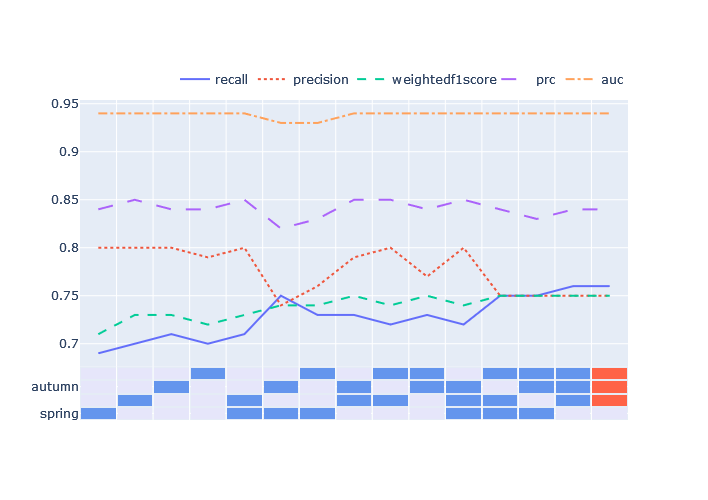

In [278]:
line_cols = ['recall', 'precision', 'weightedf1score']
line_cols += ['prc', 'auc']

line_df = best_df[[f'val_{c}' for c in line_cols]]

line_df.columns = line_cols
line_fig = px.line(
    line_df, y=line_cols, 
    line_dash='variable',
)

n_rows = 6
fig = make_subplots(
    rows=n_rows, cols=1,
    vertical_spacing=0,
    specs=[[{'rowspan': n_rows-1}],
           [{}], [{}], [{}], [{}],
           [{'rowspan': 1}]]
) 

for trace in line_fig['data']:
    fig.append_trace(trace, row=1, col=1)

fig.append_trace(
    go.Heatmap(
        z=best_df[all_seasons_names].T.to_numpy(),
        y=all_seasons_names,
        colorscale=['lavender', 'tomato', 'cornflowerblue'],
        xgap=2, ygap=2, 
        showscale=False,
    ), row=n_rows, col=1
)
        
fig.update_xaxes(
    range=(line_df.index.min()-0.5, line_df.index.max()+0.5),
    tickmode = 'linear',
    tick0 = 0.5,
    dtick = 1,
    zeroline=False,
    showticklabels=False,
    title=None,
).update_layout(
    legend_title_text=None,
    legend=dict(
        orientation='h',
        xanchor='right', yanchor='bottom',
        x=1, y=1.02   
    ),
    height=500, width=700,
)

In [5]:
from sklearn.utils import shuffle
import pandas as pd
import datetime
import geopandas as gpd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import io
import plotly.express as px

In [ ]:
all_labels = pd.read_csv(Path('data').joinpath('full_dummies.csv'))
grouped_labels = all_labels.T.groupby(
    all_labels.columns.str.split().str[0],
).max().T
all_labels.shape

In [ ]:
from sentinel_utils.SentinelUtils import normalise

In [ ]:
from time import sleep
from tqdm.notebook import tqdm
for i in tqdm(list(range(1000))):
    sleep(0.1)
    for j in tqdm(list(range(1000)), leave=False):
        sleep(1e-3)

In [ ]:
import geemap
import ee
ee.Authenticate()
ee.Initialize(project='sentinel-treeclassification')


In [ ]:
gdf = gpd.read_file(Path('data').joinpath('full_geometries.json'))
# gdf_points = gdf
# gdf_points.geometry = gdf_points.geometry.centroid

In [ ]:
import importlib
import ee_downloader 
importlib.reload(ee_downloader)

start_date = datetime.datetime(2020, 3, 1)
end_date = datetime.datetime(2024, 3, 1)
ee_downloader.EEDownloader().download_era5(
    gdf, start_date, end_date, Path('weather_data'))

In [ ]:
# df = pd.read_csv(Path('weather_data', 'era5_2020.csv'))
# df.interpolate(method='nearest')

SoilGrids250m: https://git.wur.nl/isric/soilgrids/soilgrids.notebooks/-/blob/master/markdown/access_on_gee.md

In [ ]:
import importlib
import ee_downloader 
importlib.reload(ee_downloader)
from ee_downloader import EEDownloader
from concurrent.futures import ThreadPoolExecutor

chunk_size = 100
chunks = [geometries[i: i + chunk_size] for i in range(0, geometries.shape[0], chunk_size)]


soil_dir = Path.home().joinpath('sentinel_data').joinpath('shards').joinpath('soil')
size = len(chunks)
soil_inputs = (range(size), chunks, [chunk_size]*size, [soil_dir]*size)


with ThreadPoolExecutor(max_workers=12) as pool:
    jobs = list(tqdm(pool.map(EEDownloader().download_soil, *soil_inputs), total=size))

In [ ]:
np.load(soil_file).shape

In [ ]:
np.array().shape

In [ ]:
np.stack([new_data, new_data], axis=-1).shape

In [ ]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

In [ ]:
from multiprocessing.pool import ThreadPool as Pool
from tqdm.notebook import tqdm
import sys
from IPython.display import display
from time import sleep

In [ ]:
def test_fun(t):
    a, b = t
    for i in (pbar := tqdm(range(10), leave=False)):
        pbar.set_description(f'Chunk {a}')
        sleep(0.1)

In [ ]:
test_inputs = list(zip(range(10), range(10)))

# pool = Pool(processes=2)
# list(tqdm(pool.starmap(test_fun, test_inputs, chunksize=1), total=len(test_inputs)))
# pool.close()
# pool.join()

In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
with ThreadPoolExecutor(max_workers=2) as pool:
    jobs = list(tqdm(pool.map(test_fun, test_inputs), total=len(test_inputs)))


In [ ]:
jobs[0]